In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# The GPU id to use, usually either "0" or "1"
os.environ["CUDA_VISIBLE_DEVICES"]="7"

import tensorflow as tf
from keras import backend as K
print(tf.__version__)
print(K.tensorflow_backend._get_available_gpus())

Using TensorFlow backend.


1.10.0
['/job:localhost/replica:0/task:0/device:GPU:0']


In [2]:
import numpy as np
import urllib.request
import pandas as pd
from gensim.test.utils import common_texts, get_tmpfile
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec
from tempfile import gettempdir
import zipfile
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from numpy.random import seed
from tensorflow import set_random_seed

RANDOM_SEED = 20190101

def set_random(random_seed):
    seed(random_seed)
    set_random_seed(random_seed)

set_random(RANDOM_SEED)

In [4]:
class EmoIntDataset(object):
  BASE_URL = "http://saifmohammad.com/WebDocs/"
  TRAIN_URI = "EmoInt%20Train%20Data/{}-ratings-0to1.train.txt"
  TEST_URI = "EmoInt%20Test%20Gold%20Data/{}-ratings-0to1.test.gold.txt"
  EMOTION_CLASSES = ["anger", "fear", "joy", "sadness"]
  
  THRESHOLD = 0.33
  
  def __load_data_per_class(self, url, threshold=0):
    resource = urllib.request.urlopen(url)
    np_array = np.asarray([line.split('\t') for line in [line.strip() for line in resource.read().decode('utf-8').splitlines()]])
    df = pd.DataFrame(np_array, columns=["id", "text", "emotion", "emotion_level"])
    df['emotion_level'] = df['emotion_level'].astype(float)
    df = df.query('emotion_level>' + str(threshold))
    return df[["text", "emotion"]]
  
  def load_data(self, set_threshold=False):
    train_data = None
    test_data = None
    
    for emotion in self.EMOTION_CLASSES:
      # load train dataset
      train_df = self.__load_data_per_class(self.BASE_URL + self.TRAIN_URI.format(emotion), threshold=(self.THRESHOLD if set_threshold else 0))
      
      # load test dataset
      test_df = self.__load_data_per_class(self.BASE_URL + self.TEST_URI.format(emotion), threshold=(self.THRESHOLD if set_threshold else 0))
      
      train_data = (train_df if train_data is None else train_data.append(train_df))
      test_data = (test_df if test_data is None else test_data.append(test_df))
      
    return train_data, test_data

In [5]:
emo_int_dataset = EmoIntDataset()
train_data, test_data = emo_int_dataset.load_data(set_threshold=True)
train_data, valid_data = train_test_split(train_data, test_size=0.1, random_state=RANDOM_SEED, stratify=train_data.emotion)

print(train_data.shape)
print(valid_data.shape)
print(test_data.shape)

(2610, 2)
(291, 2)
(2508, 2)


In [6]:
emotions = train_data.emotion.unique()
dic = dict()
labels = []
for i, emotion in enumerate(emotions):
    dic[emotion]=i
    labels.append(emotion)
print(dic)
print(labels)

{'fear': 0, 'joy': 1, 'anger': 2, 'sadness': 3}
['fear', 'joy', 'anger', 'sadness']


In [7]:
NUM_WORDS=20000
texts = train_data.text
tokenizer = Tokenizer(num_words=NUM_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'',
                      lower=True)
tokenizer.fit_on_texts(texts)
sequences_train = tokenizer.texts_to_sequences(texts)
sequences_valid = tokenizer.texts_to_sequences(valid_data.text)
sequences_test = tokenizer.texts_to_sequences(test_data.text)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 8591 unique tokens.


In [8]:
X_train = pad_sequences(sequences_train)
X_val = pad_sequences(sequences_valid, maxlen=X_train.shape[1])
X_test = pad_sequences(sequences_test, maxlen=X_train.shape[1])

y_train = to_categorical(np.asarray(train_data.emotion.apply(lambda x:dic[x])))
y_val = to_categorical(np.asarray(valid_data.emotion.apply(lambda x:dic[x])))
y_test = to_categorical(np.asarray(test_data.emotion.apply(lambda x:dic[x])))

print('Shape of X train, validation and test tensor:', X_train.shape, X_val.shape, X_test.shape)
print('Shape of label train, validation and test tensor:', y_train.shape, y_val.shape, y_test.shape)

Shape of X train, validation and test tensor: (2610, 34) (291, 34) (2508, 34)
Shape of label train, validation and test tensor: (2610, 4) (291, 4) (2508, 4)


In [21]:
np.save("emoint_X_train.npy", X_train)
np.save("emoint_X_val.npy", X_val)
np.save("emoint_X_test.npy", X_test)

np.save("emoint_y_train.npy", y_train)
np.save("emoint_y_val.npy", y_val)
np.save("emoint_y_test.npy", y_test)

## Word Embedding using FastText

Taken from: https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md

In [9]:
!wget https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.zip

--2018-12-20 16:52:51--  https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.28.37
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.28.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10356881291 (9.6G) [application/zip]
Saving to: 'wiki.en.zip'

wiki.en.zip         100%[===================>]   9.65G  7.89MB/s    in 28m 41s 

2018-12-20 17:21:33 (5.74 MB/s) - 'wiki.en.zip' saved [10356881291/10356881291]



In [ ]:
!mv wiki.en.zip ~/Datasets/WordEmbeddings/
!unzip ~/Datasets/WordEmbeddings/wiki.en.zip
!mv ~/Datasets/WordEmbeddings/wiki.en.bin ~/Datasets/WordEmbeddings/fasttext.wiki.en.bin
!mv ~/Datasets/WordEmbeddings/wiki.en.vec ~/Datasets/WordEmbeddings/fasttext.wiki.en.vec

In [19]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from gensim.models.keyedvectors import KeyedVectors

word_vectors = KeyedVectors.load_word2vec_format('../../Datasets/WordEmbeddings/fasttext.wiki.en.vec')

EMBEDDING_DIM=300
vocabulary_size = min(len(word_index)+1, NUM_WORDS)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
for word, i in word_index.items():
    if i>=NUM_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i] = np.random.normal(0,np.sqrt(0.25), EMBEDDING_DIM)

del(word_vectors)

from keras.layers import Embedding
embedding_layer = Embedding(vocabulary_size, EMBEDDING_DIM, weights=[embedding_matrix], trainable=True)

In [20]:
file_embedded_matrix = "emoint_embedded_matrix_fasttext_wikipedia.npy"
np.save(file_embedded_matrix, embedding_matrix)

## Reload embedding layer and training dataset

In [22]:
file_embedded_matrix = "emoint_embedded_matrix_fasttext_wikipedia.npy"
embedding_matrix = np.load(file_embedded_matrix)
print("embedding matrix shape:", embedding_matrix.shape)

embedding matrix shape: (8592, 300)


In [23]:
X_train = np.load("emoint_X_train.npy")
X_val = np.load("emoint_X_val.npy")
X_test = np.load("emoint_X_test.npy")

y_train = np.load("emoint_y_train.npy")
y_val = np.load("emoint_y_val.npy")
y_test = np.load("emoint_y_test.npy")

In [24]:
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Conv2D, MaxPooling2D, Dropout, concatenate, LSTM
from tensorflow.keras.layers import Reshape, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, Adadelta, RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
sequence_length = X_train.shape[1]
filter_sizes = [3,4,5]
num_filters = 100
drop_rate = 0.5
vocabulary_size = embedding_matrix.shape[0]
EMBEDDING_DIM=300

print(sequence_length)

inputs = Input(shape=(sequence_length,), name='input_1')
embedding_layer = Embedding(vocabulary_size, EMBEDDING_DIM, weights=[embedding_matrix], input_length=sequence_length, trainable=True, name='embedding')
embedding = embedding_layer(inputs)
reshape = Reshape((sequence_length, EMBEDDING_DIM, 1), name='reshape_1')(embedding)

conv_1 = Conv2D(num_filters, (filter_sizes[0], EMBEDDING_DIM), activation='relu',kernel_regularizer=regularizers.l2(0.01), name='conv_1')(reshape)
conv_2 = Conv2D(num_filters, (filter_sizes[1], EMBEDDING_DIM), activation='relu',kernel_regularizer=regularizers.l2(0.01), name='conv_2')(reshape)
conv_3 = Conv2D(num_filters, (filter_sizes[2], EMBEDDING_DIM), activation='relu',kernel_regularizer=regularizers.l2(0.01), name='conv_3')(reshape)

maxpool_1 = MaxPooling2D((sequence_length - filter_sizes[0] + 1, 1), strides=1, name='maxpool_1')(conv_1)
maxpool_2 = MaxPooling2D((sequence_length - filter_sizes[1] + 1, 1), strides=1, name='maxpool_2')(conv_2)
maxpool_3 = MaxPooling2D((sequence_length - filter_sizes[2] + 1, 1), strides=1, name='maxpool_3')(conv_3)

merged_tensor = concatenate([maxpool_1, maxpool_2, maxpool_3], axis=1, name='concatenate_1')
flatten = Flatten()(merged_tensor)
dropout = Dropout(drop_rate, name='dropout_1')(flatten)
output = Dense(units=4, activation='softmax',kernel_regularizer=regularizers.l2(0.01), name='dense_1')(dropout)

model = None 

# this creates a model that includes
model = Model(inputs, output)

model.summary()

34
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 300)      2577600     input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 34, 300, 1)   0           embedding[0][0]                  
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 32, 1, 100)   90100       reshape_1[0][0]                  
__________________________________________________________________________________________________
conv_2 

In [25]:
!rm -r tmp
!mkdir tmp
!ls -lA

total 2434352
drwxrwx--- 8 david david       4096 Dec 19 14:48 .git
-rw-rw---- 1 david david       1234 Dec 19 13:29 .gitignore
drwxrwx--- 2 david david       4096 Dec 20 16:44 .ipynb_checkpoints
-rw-rw---- 1 david david     175476 Dec 18 15:21 CrowdFlower_Emotion_Analysis_ConvNet.ipynb
-rw-rw---- 1 david david     144822 Dec 18 15:21 EmoInt_Embedding_Comparison.ipynb
-rw-rw---- 1 david david     108420 Dec 18 15:21 EmoInt_Emotion_Analysis_Bidirectional_LSTM_Threshold_0_33.ipynb
-rw-rw---- 1 david david     115651 Dec 18 15:21 EmoInt_Emotion_Analysis_ConvNet_LSTM_Threshold_0_33.ipynb
-rw-rw---- 1 david david      84622 Dec 18 15:21 EmoInt_Emotion_Analysis_ConvNet_Threshold_0_30.ipynb
-rw-rw---- 1 david david     133515 Dec 19 10:26 EmoInt_Emotion_Analysis_ConvNet_Threshold_0_33.ipynb
-rw-rw---- 1 david david      27061 Dec 20 17:52 EmoInt_Emotion_Analysis_ConvNet_Threshold_0_33_FastText_local.ipynb
-rw-rw---- 1 david david     141607 Dec 19 14:08 EmoInt_Emotion_Analysis_ConvNet_Thresho

In [26]:
adam = Adam(lr=1e-3, decay=0.0)
adadelta = Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
rmsprop = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

model.compile(loss='categorical_crossentropy', optimizer=rmsprop, metrics=['acc'])

filepath="tmp/weights-{epoch:02d}-{val_acc:.2f}.hdf5"
model_checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
callbacks = [early_stopping, model_checkpoint]

history = model.fit(X_train, y_train, batch_size=1000, epochs=100, verbose=1, validation_data=(X_val, y_val), callbacks=callbacks)  # starts training

/home/david/anaconda3/envs/tf36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2610 samples, validate on 291 samples
Epoch 1/100
2610/2610 [==============================] - 3s 988us/step - loss: 1.6758 - acc: 0.3088 - val_loss: 1.5023 - val_acc: 0.2749

Epoch 00001: val_acc improved from -inf to 0.27491, saving model to tmp/weights-01-0.27.hdf5
Epoch 2/100
2610/2610 [==============================] - 0s 31us/step - loss: 1.4020 - acc: 0.5176 - val_loss: 1.3646 - val_acc: 0.5052

Epoch 00002: val_acc improved from 0.27491 to 0.50515, saving model to tmp/weights-02-0.51.hdf5
Epoch 3/100
2610/2610 [==============================] - 0s 31us/step - loss: 1.2517 - acc: 0.6762 - val_loss: 1.2897 - val_acc: 0.5876

Epoch 00003: val_acc improved from 0.50515 to 0.58763, saving model to tmp/weights-03-0.59.hdf5
Epoch 4/100
2610/2610 [==============================] - 0s 33us/step - loss: 1.1947 - acc: 0.6582 - val_loss: 1.1845 - val_acc: 0.6632

Epoch 00004: val_acc improved from 0.58763 to 0.66323, saving model to tmp/weights-04-0.66.hdf5
Epoch 5/100
2610/2610 [

2610/2610 [==============================] - 0s 32us/step - loss: 0.1894 - acc: 0.9877 - val_loss: 0.4839 - val_acc: 0.8866

Epoch 00084: val_acc did not improve from 0.90034
Epoch 85/100
2610/2610 [==============================] - 0s 31us/step - loss: 0.1891 - acc: 0.9881 - val_loss: 0.4786 - val_acc: 0.8797

Epoch 00085: val_acc did not improve from 0.90034
Epoch 86/100
2610/2610 [==============================] - 0s 31us/step - loss: 0.1841 - acc: 0.9862 - val_loss: 0.4662 - val_acc: 0.8797

Epoch 00086: val_acc did not improve from 0.90034
Epoch 87/100
2610/2610 [==============================] - 0s 32us/step - loss: 0.1824 - acc: 0.9870 - val_loss: 0.4892 - val_acc: 0.8900

Epoch 00087: val_acc did not improve from 0.90034
Epoch 88/100
2610/2610 [==============================] - 0s 29us/step - loss: 0.1951 - acc: 0.9866 - val_loss: 0.4806 - val_acc: 0.8797

Epoch 00088: val_acc did not improve from 0.90034
Epoch 89/100
2610/2610 [==============================] - 0s 29us/step - 

In [27]:
model_path = 'emoint_convnet_fasttext_model.h5'
weight_path = 'emoint_convnet_fasttext_weights.h5'

model.save(model_path)
model.save_weights(weight_path)

In [28]:
!ls -lah

total 2.4G
drwxrwx--- 7 david david 4.0K Dec 20 17:53 .
drwxrwx--- 3 david david 4.0K Dec 18 16:51 ..
drwxrwx--- 8 david david 4.0K Dec 19 14:48 .git
-rw-rw---- 1 david david 1.3K Dec 19 13:29 .gitignore
drwxrwx--- 2 david david 4.0K Dec 20 16:44 .ipynb_checkpoints
-rw-rw---- 1 david david 172K Dec 18 15:21 CrowdFlower_Emotion_Analysis_ConvNet.ipynb
-rw-rw---- 1 david david 142K Dec 18 15:21 EmoInt_Embedding_Comparison.ipynb
-rw-rw---- 1 david david 106K Dec 18 15:21 EmoInt_Emotion_Analysis_Bidirectional_LSTM_Threshold_0_33.ipynb
-rw-rw---- 1 david david 113K Dec 18 15:21 EmoInt_Emotion_Analysis_ConvNet_LSTM_Threshold_0_33.ipynb
-rw-rw---- 1 david david  83K Dec 18 15:21 EmoInt_Emotion_Analysis_ConvNet_Threshold_0_30.ipynb
-rw-rw---- 1 david david 131K Dec 19 10:26 EmoInt_Emotion_Analysis_ConvNet_Threshold_0_33.ipynb
-rw-rw---- 1 david david  35K Dec 20 17:52 EmoInt_Emotion_Analysis_ConvNet_Threshold_0_33_FastText_local.ipynb
-rw-rw---- 1 david david 139K Dec 19 14:08 EmoInt_Emotion_An

In [29]:
sequences_test=tokenizer.texts_to_sequences(test_data.text)
X_test = pad_sequences(sequences_test, maxlen=X_test.shape[1])
y_pred = model.predict(X_test)

In [30]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [31]:
y_pred_original = [labels[val] for val in np.argmax(y_pred, axis=1).squeeze()]
y_test_original = np.asarray(test_data.emotion)

In [32]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (4,3), fontsize=15):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [33]:
cf_matrix = confusion_matrix(y_test_original, y_pred_original, labels=labels)

df_cm = pd.DataFrame(
    cf_matrix, index=labels, columns=labels, 
)

df_cm

,fear,joy,anger,sadness
fear,633,21,33,102
joy,18,493,7,25
anger,39,12,543,49
sadness,38,7,28,460


Figure(288x216)


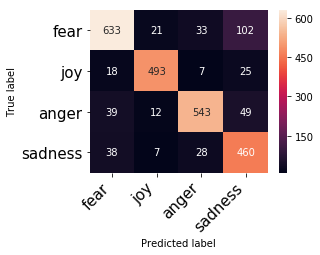

In [34]:
print(print_confusion_matrix(cf_matrix, class_names=labels))

In [35]:
test_accuracy = accuracy_score(y_test_original, y_pred_original)
print("test accuracy:", test_accuracy)

test accuracy: 0.8488835725677831


### Performance score for each classes

In [36]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test_original, y_pred_original)
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support.round(4)
}
score_df = pd.DataFrame(score_dict, index=labels)
score_df

,precision,recall,f1-score,support
fear,0.8887,0.8445,0.8660,643
joy,0.8695,0.8023,0.8345,789
anger,0.9250,0.9079,0.9164,543
sadness,0.7233,0.8630,0.7870,533


### Performance score using micro average

In [37]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test_original, y_pred_original, average="micro")
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support
}
score_df = pd.DataFrame(score_dict, index=["score"])
score_df

,precision,recall,f1-score,support
score,0.8489,0.8489,0.8489,None


### Performance score using macro average

In [38]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test_original, y_pred_original, average="macro")
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support
}
score_df = pd.DataFrame(score_dict, index=["score"])
score_df

,precision,recall,f1-score,support
score,0.8516,0.8544,0.851,None


### Performance score using weighted average

In [39]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test_original, y_pred_original, average="weighted")
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support
}
score_df = pd.DataFrame(score_dict, index=["score"])
score_df

,precision,recall,f1-score,support
score,0.8554,0.8489,0.8502,None


In [40]:
from sklearn.metrics import cohen_kappa_score

kappa_score = cohen_kappa_score(y_test_original, y_pred_original, labels=labels)
print("kappa:", kappa_score)

kappa: 0.7975175485984127
